In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data_path = '/Users/as274094/GitHub/Refractored_star_classifier/tensorflow_version/'
dataset = np.load(data_path + 'PCA_dataset1.npy', allow_pickle=True)[()]

x_train = dataset['train_stars_pca']
x_val = dataset['validation_stars_pca']
x_test = dataset['test_stars_pca']
y_train = dataset['train_C']
y_val = dataset['validation_C']
y_test = dataset['test_C']
SED_test = dataset['test_SEDs']


In [3]:
# Hyperparameters
PCA_components = 24
model_learning_rate = 0.05
N_epochs = 25
N_committee = 48

In [4]:
def SEDlisttoC(SED_list):
    sed_array = np.array(SED_list)
    return sed_array*0.5 + 1.5

def CtoSEDarray(c_values, variance):
    sed_classes = ((c_values - 1.25) // 0.5).astype(int)
    sed_classes = np.where((c_values < 1.25) | (c_values > 7.75), 20, sed_classes)
    sed_classes = np.where((variance > 1.00), 20, sed_classes)
    return sed_classes

def calculate_success_rate(confusion_matrix):
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

In [7]:
# Define the model architecture

initializer = tf.keras.initializers.GlorotNormal(seed = 1)
model = tf.keras.Sequential([
    layers.Dense(26, input_shape=[PCA_components], activation='sigmoid', kernel_initializer= initializer),
    layers.Dense(26, activation='sigmoid', kernel_initializer= initializer),
    layers.Dense(1, activation = 'linear', kernel_initializer= initializer)
])
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = model_learning_rate)
)


1/1 [==============================] - 0s 67ms/step


In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights=True)
progbar_logger = tf.keras.callbacks.ProgbarLogger()

start_time = time.time() # Measure execution time
learning = model.fit(x_train, y_train, epochs= N_epochs, callbacks = [progbar_logger,early_stopping], validation_data=(x_val,y_val)) # Train the model

# Calculate the execution time
end_time = time.time()
execution_time = end_time - start_time

C_pred = model.predict(x_test, verbose = 1).reshape(-1) # Predict the scalar parameter C
SED_pred = CtoSEDarray(C_pred,np.zeros_like(C_pred))


In [20]:
# Evaluate the performance of the classifier

mse = np.mean((y_test - y_pred)**2)
print('MSE:', mse)

f1 = f1_score(SED_test, SED_pred, average = None)
print('\nF1 score for each class:', f1)
print('Average F1 score:',np.mean(f1[:13]))

confusion_matrix = tf.math.confusion_matrix(SED_test, SED_pred) 
print("\nConfusion matrix:")
print(confusion_matrix)

success_rate = calculate_success_rate(confusion_matrix)
print('\nSuccess rate:', success_rate)

print("Execution time:", execution_time, "seconds")


MSE: 2.462505780239917

F1 score: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
0 4.247594 5
11 4.247595 5
4 4.24759 5
7 4.2476025 5
6 4.247599 5
3 4.2475886 5
3 4.247602 5
4 4.2475963 5
9 4.247593 5
8 4.247597 5

Confusion matrix:
tf.Tensor(
[[0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]], shape=(12, 12), dtype=int32)

Success rate: 0.3
Execution time: 2.293637275695801 seconds


In [9]:
#Save the committee models
import os

# Create a directory to save the models
os.makedirs("single_model", exist_ok=True)
model.save(f"single_model/my_model.h5")

Text(0.5, 1.0, 'Loss function evolution')

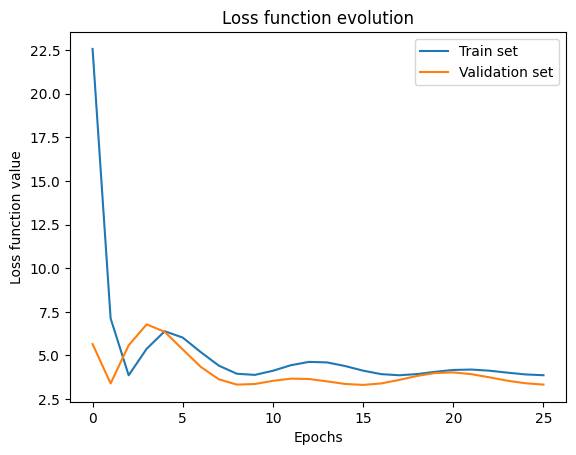

In [12]:
loss_evolution = learning.history["loss"]
val_loss_evolution = learning.history["val_loss"]

plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epochs")
plt.ylabel("Loss function value")
plt.legend()
plt.title("Loss function evolution")
